# Inspect Data


In [1]:
import zarr
import os
import numpy as np
import hashlib
import matplotlib.pyplot as plt 

def create_lut(labels):
    labels = labels.astype(np.int64)  # ensure labels are integer
    max_label = np.max(labels)
    lut = np.zeros((int(max_label + 1), 4), dtype=np.uint8)
    lut[:, 3] = 255  # alpha channel
    for label in range(1, int(max_label + 1)):
        # Generate a deterministic RGB color based on label
        md5 = hashlib.md5()
        md5.update(str(label).encode('utf-8'))
        color_hash = md5.hexdigest()
        lut[label, :3] = [int(color_hash[i:i+2], 16) for i in (0, 2, 4)]
    colored_labels = lut[labels]
    return colored_labels

In [6]:
# Open the Zarr object
data = zarr.open('/data/base/3M-APP-SCN/01_data/CompImBio800M.zarr', mode='r')

# Access the 'raw' dataset
raw_dataset = data['raw']

# Get the shape of the first layer (assuming it's 3D: depth, height, width)
depth, height, width = raw_dataset.shape[:3]

# Read the first layer into memory
first_layer = raw_dataset[0, :, :]

# Calculate min, max, and mean
min_val = np.min(first_layer)
max_val = np.max(first_layer)
mean_val = np.mean(first_layer)

print(f"Min: {min_val}, Max: {max_val}, Mean: {mean_val}")


Min: 85, Max: 220, Mean: 175.61971575


Text(0.5, 1.0, 'Ground truth')

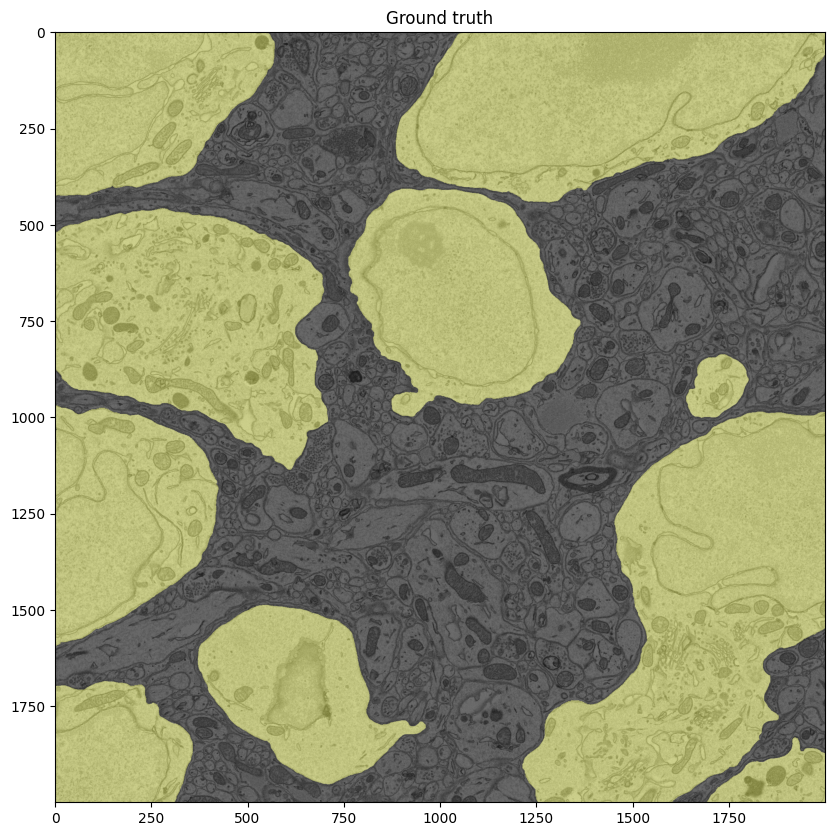

In [7]:


layer = 50
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True, squeeze=False)
# We transpose the layer so that matplotlib displays the image normally
raw = data['raw'][layer,:,:]
labels = data['labels_new'][layer,:,:]
# raw = data[layer]
# seed_layer = seeds[layer]
# boundary_distances_layer = boundary_distances[layer]

axes[0][0].imshow(raw, cmap='gray')
axes[0][0].imshow(create_lut(np.squeeze(labels)), alpha=0.5)
axes[0][0].set_title("Ground truth")

Text(0.5, 1.0, 'Ground truth')

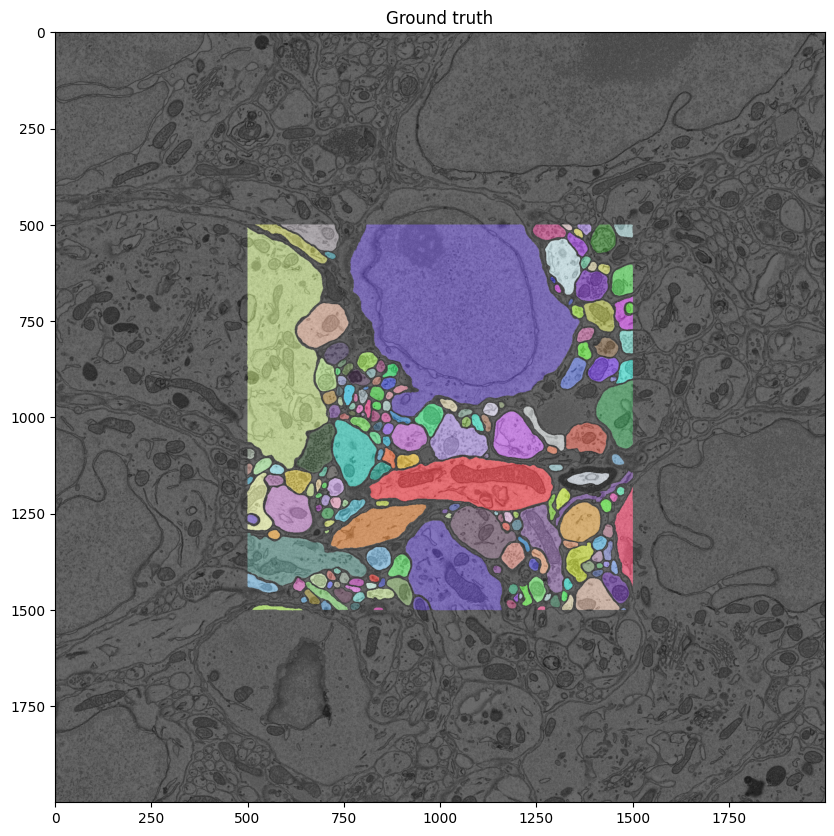

In [8]:


layer = 50
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True, squeeze=False)
# We transpose the layer so that matplotlib displays the image normally
raw = data['raw'][layer,:,:]
labels = data['labels_old'][layer,:,:]
# raw = data[layer]
# seed_layer = seeds[layer]
# boundary_distances_layer = boundary_distances[layer]

axes[0][0].imshow(raw, cmap='gray')
axes[0][0].imshow(create_lut(np.squeeze(labels)), alpha=0.5)
axes[0][0].set_title("Ground truth")

Text(0.5, 1.0, 'Ground truth')

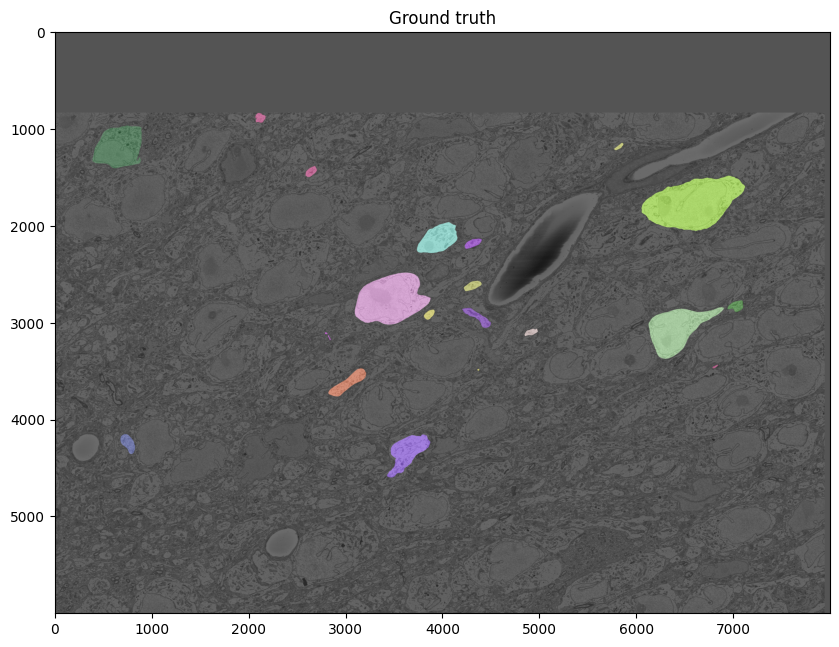

In [7]:
layer = 151
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True, squeeze=False)
# We transpose the layer so that matplotlib displays the image normally
raw = np.flipud(data['raw'][layer,:,:])
labels = np.flipud(data['labels'][layer,:,:])
# raw = data[layer]
# seed_layer = seeds[layer]
# boundary_distances_layer = boundary_distances[layer]

axes[0][0].imshow(raw, cmap='gray')
axes[0][0].imshow(create_lut(np.squeeze(labels)), alpha=0.5)
axes[0][0].set_title("Ground truth")

In [17]:
data['raw']

<zarr.core.Array '/raw' (3000, 4500, 300) uint8 read-only>

# Transpose Data

The LSD model requires Zarr datasets to be in z,y,x format (50,10,10) nm.

Create new datasets that are in z,y,x format

In [21]:
# LSD needs zarr in z,y,x format

# Currently in (3000, 4500, 300) format
# WebKnossos Zarr should be in x,y,z ordering e.g. (300, 4500, 3000)


def tranpose_zarr_dataset(zarr_data: zarr.hierarchy.Group, old_dataset: str, 
                          tranpose_order: tuple, new_dataset=None, dtype=None):
    # tranpose_order -> (2,1,0)
    assert type(tranpose_order) is tuple and len(tranpose_order) == 3
    a,b,c = tranpose_order
    if new_dataset is None:
        new_dataset = old_dataset + "_transposed"
    
    # Access the original dataset
    dataset = zarr_data[old_dataset]
    print(f"Old dataset {old_dataset} shape: {dataset.shape}")

    if dtype is None:
        dtype = dataset.dtype

    print(f"Dtype: {dtype}")

    # Create a new dataset for the transposed data
    # The new shape is the transposed shape of the original data
    # The dtype is uint8 as you wanted to change the data type as well
    dataset_transposed = zarr_data.create_dataset(new_dataset, 
                                                  shape=(
                                                      dataset.shape[tranpose_order[0]], 
                                                      dataset.shape[tranpose_order[1]], 
                                                      dataset.shape[tranpose_order[2]]), 
                                                  dtype=dtype)

    # Iterate over the original dataset in chunks
    for z in range(0, dataset.shape[0], dataset.chunks[0]):
        print(f"Z: {z}", end="\r")
        for y in range(0, dataset.shape[1], dataset.chunks[1]):
            for x in range(0, dataset.shape[2], dataset.chunks[2]):
                # Read a chunk of data
                chunk = dataset[z:z+dataset.chunks[0], y:y+dataset.chunks[1], x:x+dataset.chunks[2]]

                # Transpose and change dtype of the chunk
                transposed_chunk = chunk.transpose(tranpose_order[0], tranpose_order[1], tranpose_order[2]).astype(dtype)

                # Determine the target location in the new dataset
                target_z = x
                target_y = y
                target_x = z

                # Write the transposed chunk to the new dataset
                dataset_transposed[target_z:target_z+transposed_chunk.shape[0], target_y:target_y+transposed_chunk.shape[1], target_x:target_x+transposed_chunk.shape[2]] = transposed_chunk

    # Verify the shape of the new dataset
    print("Transposed shape:", dataset_transposed.shape)
    return dataset_transposed

data = zarr.open('/data/base/3M-APP-SCN/01_data/APP-3M-SCN-SomaGT.zarr', mode='r+')

tranpose_zarr_dataset(data, 'raw', (2,1,0), 'raw_zyx', np.uint8)
tranpose_zarr_dataset(data, 'labels', (2,1,0), 'labels_zyx', np.uint8)

Old dataset raw shape: (3000, 4500, 300)
Dtype: <class 'numpy.uint8'>
Transposed shape: (300, 4500, 3000)
Old dataset labels shape: (3000, 4500, 300)
Dtype: <class 'numpy.uint8'>
Transposed shape: (300, 4500, 3000)


<zarr.core.Array '/labels_zyx' (300, 4500, 3000) uint8>

In [3]:
import zarr
data = zarr.open('/data/base/3M-APP-SCN/01_data/APP-3M-SCN-SomaGT.zarr', mode='r+')

# Use 50,10,10 instead of 50,8,8 since the model is trained on 50,10,10 data
data['raw'].attrs['offset'] = [0, 0, 0]
data['raw'].attrs['resolution'] = [50, 10, 10]

data['soma'].attrs['offset'] = [0, 0, 0]
data['soma'].attrs['resolution'] = [50, 10, 10]

In [4]:
[x*y for x,y in zip(data['raw'].shape, data['raw'].attrs['resolution'])]

[15000, 45000, 30000]

In [21]:
# Given data
# 10816/14036 [34:41
batches_processed = 10816
total_batches = 14036
time_passed_minutes = 34
time_passed_seconds = 41

# Convert the total time passed into minutes
total_time_passed = time_passed_minutes + time_passed_seconds / 60

# Calculate average time per batch
avg_time_per_batch = total_time_passed / batches_processed

# Estimate total time for all batches
estimated_total_time = avg_time_per_batch * total_batches

# Convert the estimated total time back to minutes and seconds
estimated_total_minutes = int(estimated_total_time)
estimated_total_seconds = int((estimated_total_time - estimated_total_minutes) * 60)

estimated_total_time, estimated_total_minutes, estimated_total_seconds

remaining_minutes = estimated_total_minutes - time_passed_minutes
remaining_seconds = estimated_total_seconds - time_passed_seconds

print(f"Estimated total time: {estimated_total_minutes}m:{estimated_total_seconds}s")
print(f"Estimated time remaining: {remaining_minutes}m:{remaining_seconds}s")



Estimated total time: 45m:0s
Estimated time remaining: 11m:-41s


## Soma Mask

This step is done for inference, where we do not want to predict soma and other large bodies. Masking out these objects should improve the performance of the model and minimize the number of false merges / splits. 

In [3]:
# The soma dataset should be inverted to properly function as the mask

data = zarr.open('/data/base/3M-APP-SCN/01_data/APP-3M-SCN-SomaGT.zarr', mode='r+')

# Access the 'soma' dataset
# soma_dataset = data['soma']
soma_dataset = data['soma_segmentation_0.3_filtered']

depth, height, width = soma_dataset.shape
print(depth, height, width)


300 4500 3000


In [4]:
# Create an empty array for the soma mask with the same shape as 'soma_dataset'
# It's crucial to use the same data type (uint8) for saving space and ensuring compatibility
soma_mask = np.empty((depth, height, width), dtype='uint8')

# Process each layer to avoid loading the entire dataset into memory if it's large
for d in range(depth):
  print(f'Layer: {d}', end='\r')
  layer = soma_dataset[d, :, :]  # Read the current layer
  # Create the binary mask: 0 becomes 1, anything else becomes 0
  mask_layer = np.where(layer > 0, 0, 1).astype('uint8')  # Ensure the data type is uint8
  soma_mask[d, :, :] = mask_layer  # Store the processed layer in the mask array

# Save the binary mask as a new dataset in the Zarr file
# This step assumes 'data' has been opened with mode='a' to allow writing
data.create_dataset('soma_mask_0.3', data=soma_mask, dtype='uint8')

data['soma_mask_0.3'].attrs['offset'] = [0, 0, 0]
data['soma_mask_0.3'].attrs['resolution'] = [50, 10, 10]

ContainsArrayError: path 'soma_mask' contains an array

In [6]:
data['raw'].shape

(300, 4500, 3000)

Text(0.5, 1.0, 'Ground truth')

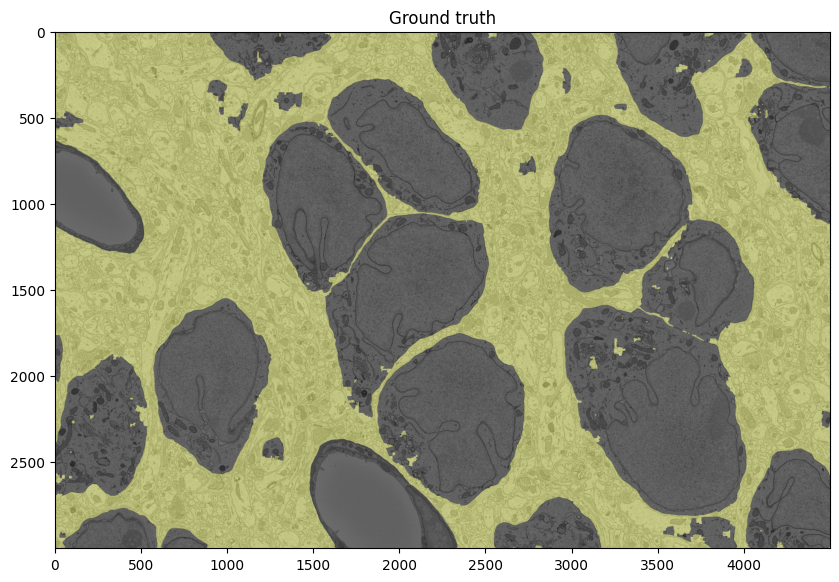

In [7]:
layer = 150
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True, squeeze=False)
# We transpose the layer so that matplotlib displays the image normally
# Access layer in z,y,x format
raw = data['raw'][layer,:,:].T
labels = data['soma_mask_0.3'][layer,:,:].T
# raw = data[layer]
# seed_layer = seeds[layer]
# boundary_distances_layer = boundary_distances[layer]

axes[0][0].imshow(raw, cmap='gray')
axes[0][0].imshow(create_lut(np.squeeze(labels)), alpha=0.5)
axes[0][0].set_title("Ground truth")

## Proceed to Prediction Pipeline

The prediction scripts are located in: 

/data/base/3M-APP-SCN/02_train/setup04/

A useful notebook for processing the pipeline can be found at /data/base/3M-APP-SCN/02_train/setup04/prediction_pipeline.ipynb

